In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Single Step Kalman Filter
$$
\begin{aligned}
&\textbf{Filter}\left(m_{t-1}, P_{t-1}, A, Q, H, R, y\right): \\
&\quad m_t^{-} = A m_{t-1} \quad \text{// predictive mean} \\
&\quad P_t^{-} = A P_{t-1} A^{\top} + Q \quad \text{// predictive covariance} \\
&\quad z = y - H m_t^{-} \quad \text{// residual} \\
&\quad S = H P_t^{-} H^{\top} + R \quad \text{// innovation covariance} \\
&\quad K = P_t^{-} H^{\top} S^{-1} \quad \text{// gain} \\
&\quad m_t = m_t^{-} + K z \quad \text{// updated mean} \\
&\quad P_t = (I - K H) P_t^{-} \quad \text{// updated covariance} \\
&\quad \textbf{return } (m_t, P_t), (m_t^{-}, P_t^{-})
\end{aligned}
$$

In [5]:
def filter(m_t_minus, P_t_minus, A, Q, H, R, y):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    z = y - H @ m_t_minus
    S = H @ P_t_minus @ H.T + R
    K = P_t_minus @ H.T @ np.linalg.inv(S)
    m_t = m_t_minus + K @ z 
    P_t = (np.eye(len(K)) - K @ H) @ P_t_minus
    return (m_t, P_t), (m_t_minus, P_t_minus)




In [6]:
def smoother(m_t, P_t, A, m_t_plus_1_bar, P_t_plus_1_bar, m_t_plus_1_s, P_t_plus_1_s):
    G = P_t @ A.T @ np.linalg.inv(P_t_plus_1_bar)
    m_t_s = m_t + G @ (m_t_plus_1_s - m_t_plus_1_bar)
    P_t_s = P_t + G @ (P_t_plus_1_s - P_t_plus_1_bar) @ G.T
    return m_t_s, P_t_s

In [7]:
def predict(m_0, P_0, A_sequence, Q_sequence, H_sequence, y_sequence, R_sequence):

    # Initialize sequences with initial values
    m_sequence = [m_0]
    P_sequence = [P_0]
    
    # Get the number of time steps
    num_steps = len(A_sequence)
    
    # Iterate from t=1 onwards
    for t in range(num_steps):
        # Get current parameters
        A_t = A_sequence[t]
        Q_t = Q_sequence[t]
        H_t = H_sequence[t]
        y_t = y_sequence[t]
        R_t = R_sequence[t]
        
        # Get previous state estimates
        m_t_minus_1 = m_sequence[t]
        P_t_minus_1 = P_sequence[t]
        
        # Apply FILTER function
        (m_t, P_t), (m_t_minus, P_t_minus) = filter(m_t_minus_1, P_t_minus_1, A_t, Q_t, H_t, R_t, y_t)
        
        # Store results
        m_sequence.append(m_t)
        P_sequence.append(P_t)
    
    return m_sequence, P_sequence

### Exp 1: Logistic ODE

$$ \dot{x} = x * (1 - x), \quad x_0 = 0.01$$




In [2]:
f = lambda x: x * (1 - x)
#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))


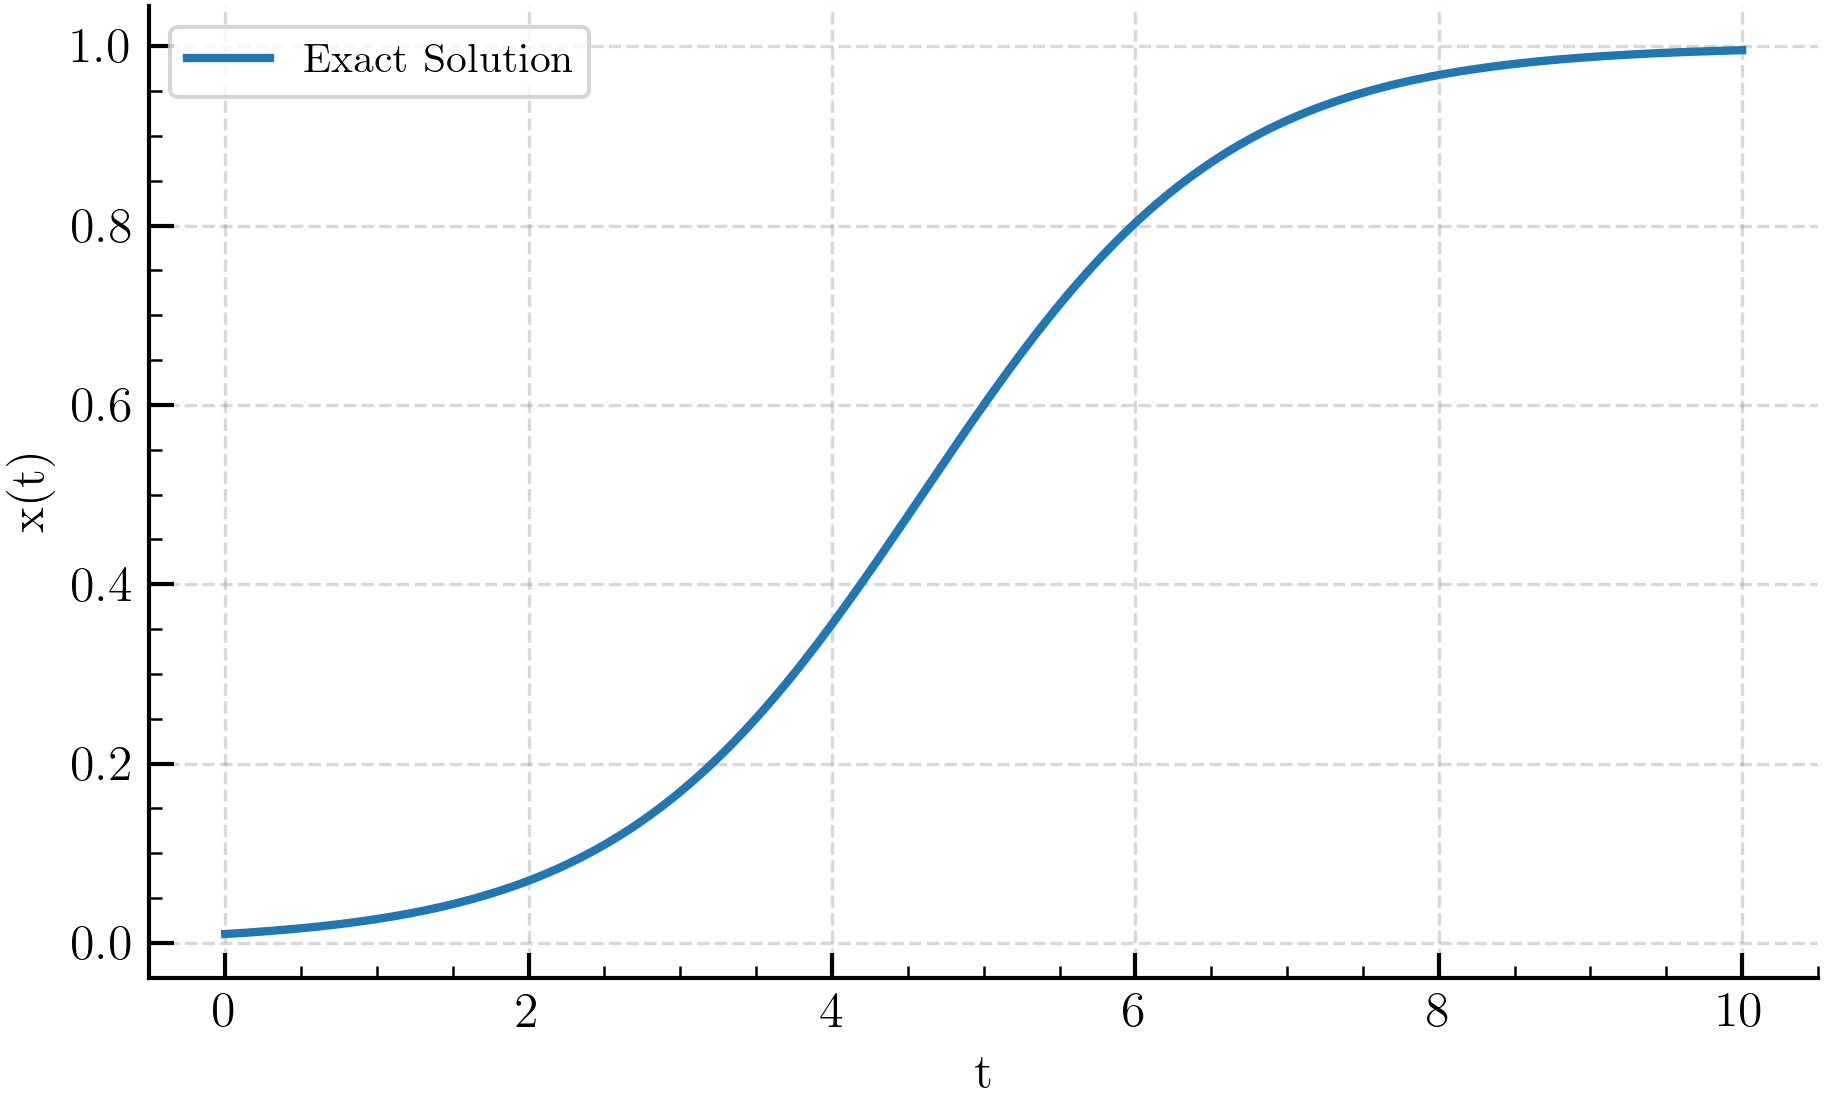

In [6]:
t = np.linspace(0, 10, 200)
plt.plot(t, x_exact(t), label='Exact Solution')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.show()
